In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def char_tokenize(sequence):
    return list(sequence)

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_dim, embedding_dim, hidden_dim, num_layer):
        super(SimpleRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layer, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, vocab_dim)


    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.permute(0, 2, 1)
        return x

In [4]:
def text2tensor(sequence, token2idx, input_len, vocab):
    new_sequence = [token2idx['<BOS>'], ]
    mask = [1, ]
    seq_len = len(sequence)
    for i in range(input_len - 2):
        is_end = True
        if i < seq_len - 3:
            if sequence[i] in vocab:
                new_sequence.append(token2idx[sequence[i]])
                mask.append(1)
            else:
                new_sequence.append(token2idx['<UNK>'])
                mask.append(0)
        else:
            if is_end:
                mask.append(1)
                is_end = False
            else:
                mask.append(0)

            new_sequence.append(token2idx['<EOS>'])
    
    if seq_len > input_len:
        mask.append(1)
    else:
        mask.append(0)
    new_sequence.append(token2idx['<EOS>'])

    new_sequence = torch.tensor(new_sequence)
    mask = torch.tensor(mask)
    assert len(new_sequence) == input_len, f'{len(new_sequence), input_len, seq_len}'
    return new_sequence, mask

In [5]:
class TextDataset(Dataset):
    def __init__(self, data, tokenizer, token2idx, input_len, vocab):
        self.data = data
        self.tokenizer = tokenizer
        self.token2idx = token2idx
        self.input_len = input_len
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data.iloc[idx, 0]
        sequence = self.tokenizer(sequence)
        sequence, mask = text2tensor(sequence, self.token2idx, self.input_len, self.vocab)
        return sequence[:-1], sequence[1:], mask[1:]


In [6]:
def get_vocabulary(data, ban_words, new_words, vocab_size, tokenizer, threshold):
    vocabulary = {new_word: 1 for new_word in new_words}
    filtered_vocabulary = new_words
    count = len(vocabulary)
    for frame in tqdm(data):
        for i in trange(len(frame)):
            sequence = frame.iloc[i, 0]
            for token in tokenizer(sequence):
                if token not in ban_words and count < vocab_size:
                    if token not in vocabulary:
                        vocabulary[token] = 1
                    else:
                        vocabulary[token] += 1
                    count += 1

    for token, count in vocabulary.items():
        if count > threshold:
           filtered_vocabulary.append(token)

    print(f'Vocabulary len={len(filtered_vocabulary)}')
    return filtered_vocabulary

In [7]:
def choose_device(model, device, parallel_type):
    if device == 'cpu':
        model = model.to(device)
        print(f'device={device}')
    else:
        if parallel_type == 'ddp':
            model = torch.nn.parallel.DistributedDataParallel(model)
            print(f'devices={list(range(torch.cuda.device_count()))}')
        elif parallel_type == 'dp':
            model = torch.nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
            model = model.to(device)
            print(f'devices={list(range(torch.cuda.device_count()))}')
        elif parallel_type is None:
            print(f'devices={[0]}')
            model = model.to(device)

    return model

In [8]:
def save_training(losses, best_epoch):
    print(f'Training is complete, best epoch: {best_epoch}')

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(losses['train'], label='Train Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss value')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(losses['valid'], label='Valid Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss value')
    axs[1].grid()
    axs[1].legend()

    plt.show()

In [9]:
def train_loop(model, dataloader, loss_func, optimizer, parallel_type, device, early_stopping, scheduler=None, epochs=10):
    losses = {
        'train': [],
        'valid': []
    }
    best_loss = np.inf
    best_epoch = 0
    best_model = None
    
    for epoch in range(epochs):
        for phase in ('train', 'valid'):
            total_loss = 0
            for batch in tqdm(dataloader[phase]):
                inputs, labels, mask = batch
                inputs, labels, mask = inputs.to(device), labels.to(device), mask.to(device)
                
                model.train(phase == 'train')
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    loss = (loss * mask).sum()
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        loss = (loss * mask).sum()

                batch_loss = loss.item() / mask.sum()
                losses[phase].append(batch_loss.detach().cpu().numpy())
                total_loss += batch_loss
            

            epoch_loss = total_loss / len(dataloader)

            if phase =='train' and scheduler is not None:
                scheduler.step()

            if phase == 'valid':
                print('Epoch', epoch+1)
                print('Train Loss:', losses['train'][-1])
                print('Valid Loss:', losses['valid'][-1])
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model = model
                    best_epoch = epoch
                    print('Best score!')
                if epoch - best_epoch == early_stopping:
                    save_training(
                        losses, best_epoch
                    )
                    if parallel_type == None:
                        return best_model
                    else:
                        return best_model.module

                print()

    save_training(
        losses, best_epoch
    )

    if parallel_type == None:
        return best_model
    else:
        return best_model.module


In [10]:
def set_seed(seed):
    np.random.seed(seed)
    np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [11]:
def softmax(x, T=1.0, eps=1e-8):
    if T == 1:
        x_sum = x.sum()
        return x / x_sum
    else:
        x_exp = np.exp(x / T + eps)
        x_sum = x_exp.sum()
        return x_exp / x_sum

In [12]:
def test(best_model, prompt,  tokenizer, token2idx, idx2token, vocabulary, device, generation_len=100, T=1, use_argmax=True):
    best_model.eval()
    with torch.no_grad():
        while True:
            sequence = tokenizer(prompt)
            sequence, mask = text2tensor(prompt, token2idx, len(sequence), vocabulary)
            sequence = sequence[:-1].to(device)
            sequence = sequence.unsqueeze(0)
            pred = best_model(sequence).squeeze(0).cpu().numpy()[:, -1]
            # probs = torch.softmax(last_logits, 0).cpu()
            probs = softmax(pred, T=T)
            if use_argmax:
                next_token = idx2token[probs.argmax(0)]
            else:
                next_token = np.random.choice(vocabulary, p=probs)

            prompt = prompt + next_token

            if next_token == '<EOS>' or len(prompt) > generation_len:
                break

    return prompt        

In [13]:
train_path = r'/root/storage/3030/AkhmetzyanovD/projects/mai/cnn_dailymail/train.csv'
valid_path = r'/root/storage/3030/AkhmetzyanovD/projects/mai/cnn_dailymail/valid.csv'
train_data = pd.read_csv(train_path, usecols=['article'])
valid_data = pd.read_csv(valid_path, usecols=['article'])

In [14]:
train_data = train_data.head(int(len(train_data) / 4))

In [15]:
train_data.head(10)

,article
0,By . Associated Press . PUBLISHED: . 14:11 EST...
1,(CNN) -- Ralph Mata was an internal affairs li...
2,A drunk driver who killed a young woman in a h...
3,(CNN) -- With a breezy sweep of his pen Presid...
4,Fleetwood are the only team still to have a 10...
5,He's been accused of making many a fashion fau...
6,By . Daily Mail Reporter . PUBLISHED: . 01:15 ...
7,By . Daily Mail Reporter . This is the moment ...
8,There are a number of job descriptions waiting...
9,"Canberra, Australia (CNN) -- At first glance, ..."


In [16]:
device = 'cuda:0'
parallel_type = 'dp'

In [17]:
prompt = 'This will create a '

## RNN with char tokenizer

In [18]:
ban_words = ['\t', '\n', '\u2009', '\xa0', '|', '´', '’',  '‘', '–', 'ñ', 'â' , '“', '½', 'Î', 'í', 'ó', 'Â', 'Ã', 'ﬁ', '¿', '•', 'É', 'è', 'š', 'ū', 'ė', 'č', '¢', 'é', 'ô']
new_words = ['<EOS>', '<BOS>', '<UNK>']
vocabulary = ['<EOS>', '<BOS>', '<UNK>', 'B', 'y', ' ', '.', 'A', 's', 'o', 'c', 'i', 'a', 't', 'e', 'd', 'P', 'r', 'U', 'L', 'I', 'S', 'H', 'E', 'D', ':', '1', '4', 'T', ',', '2', '5', 'O', 'b', '0', '3', '6', 'h', 'p', 'f', 'F', 'g', 'C', 'l', 'n', 'N', 'k', 'x', 'u', 'm', 'G', 'J', 'w', 'v', '(', ')', 'z', 'M', "'", '-', 'R', '"', '9', 'K', 'W', 'j', '7', '8', '[', ']', 'Y', 'q', 'V', '$', '%', 'Q', '£', '/', '!', 'Z', '¬', '#', ';', '©', '&', '@', '_', '?', '*', 'X', '—', '+', '…', '»', '”', '€', '<', '{', '}']
vocab_size = 99
# vocabulary =  get_vocabulary([train_data, valid_data], ban_words, new_words, vocab_size, word_tokenize, 0)
vocab_size = len(vocabulary)

In [19]:
token2idx = {token: i for i, token in enumerate(vocabulary)}
idx2token = {i: token for i, token in enumerate(vocabulary)}

In [20]:
train_dataset = TextDataset(train_data, char_tokenize, token2idx, input_len=512, vocab=vocabulary)
valid_dataset = TextDataset(valid_data, char_tokenize, token2idx, input_len=512, vocab=vocabulary)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=1408, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=1408, shuffle=False)
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

In [22]:
model = SimpleRNN(vocab_dim=vocab_size, embedding_dim=300, hidden_dim=128, num_layer=5)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
scheduler = None

In [23]:
model = choose_device(model, device, parallel_type)

devices=[0, 1]


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch 1
Train Loss: 3.1990807
Valid Loss: 3.1412303
Best score!



100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Epoch 2
Train Loss: 3.153346
Valid Loss: 3.092504
Best score!



100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


Epoch 3
Train Loss: 2.8411055
Valid Loss: 2.7942822
Best score!

Training is complete, best epoch: 2


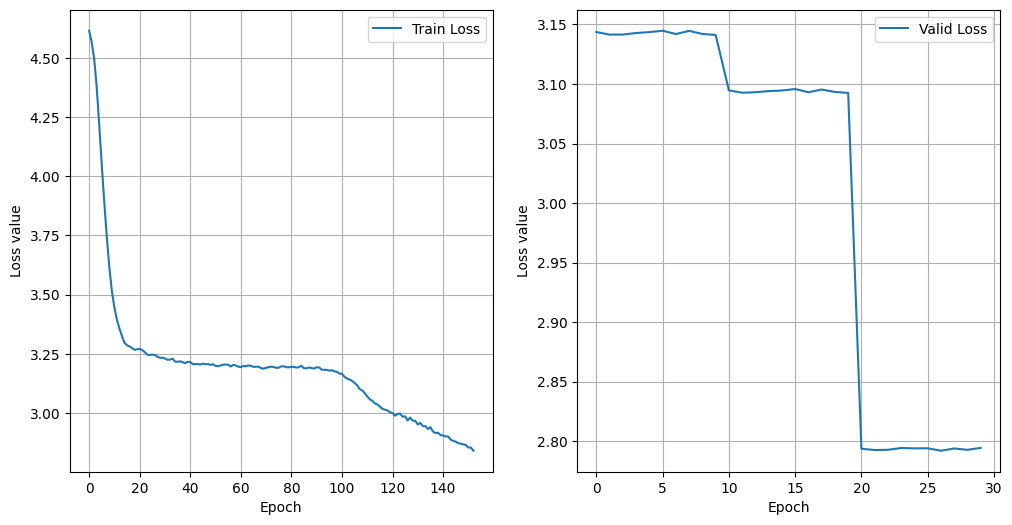

In [24]:
best_model = train_loop(
    model=model, 
    dataloader=dataloaders, 
    loss_func=loss_fn,
    optimizer=optimizer,
    parallel_type=parallel_type, 
    device=device, 
    early_stopping=3, 
    scheduler=scheduler, 
    epochs=3
    )

In [25]:
text1 = test(
    best_model, 
    prompt, 
    char_tokenize, 
    token2idx, 
    idx2token, 
    vocabulary, 
    device, 
    generation_len=100, 
    T=0.4, 
    use_argmax=True
)

In [26]:
print(text1)

This will create a published into journal and all.


## RNN with word tokenizer

In [27]:
ban_words = ['\t', '\n', '\u2009', '\xa0', '(CNN)']
new_words = ['<EOS>', '<BOS>', '<UNK>']
vocabulary = ['<EOS>', '<BOS>', '<UNK>', 'By', '.', 'Associated', 'Press', 'PUBLISHED', ':', '14:11', 'EST', ',', '25', 'October', '2013', '|', 'UPDATED', '15:36', 'The', 'bishop', 'of', 'the', 'Fargo', 'Catholic', 'Diocese', 'in', 'North', 'Dakota', 'has', 'exposed', 'potentially', 'hundreds', 'church', 'members', 'Grand', 'Forks', 'and', 'Jamestown', 'to', 'hepatitis', 'A', 'virus', 'late', 'September', 'early', 'state', 'Health', 'Department', 'issued', 'an', 'advisory', 'exposure', 'for', 'anyone', 'who', 'attended', 'five', 'churches', 'took', 'communion', 'Bishop', 'John', 'Folda', '(', 'pictured', ')', 'State', 'Immunization', 'Program', 'Manager', 'Molly', 'Howell', 'says', 'risk', 'is', 'low', 'but', 'officials', 'feel', 'it', "'s", 'important', 'alert', 'people', 'possible', 'diocese', 'announced', 'on', 'Monday', 'that', 'taking', 'time', 'off', 'after', 'being', 'diagnosed', 'with', 'he', 'contracted', 'infection', 'through', 'contaminated', 'food', 'while', 'attending', 'a', 'conference', 'newly', 'ordained', 'bishops', 'Italy', 'last', 'month', 'Symptoms', 'include', 'fever', 'tiredness', 'loss', 'appetite', 'nausea', 'abdominal', 'discomfort', 'where', 'located', 'CNN', '--', 'Ralph', 'Mata', 'was', 'internal', 'affairs', 'lieutenant', 'Miami-Dade', 'Police', 'working', 'division', 'investigates', 'allegations', 'wrongdoing', 'by', 'cops', 'Outside', 'office', 'authorities', 'allege', '45-year-old', 'longtime', 'officer', 'worked', 'drug', 'trafficking', 'organization', 'help', 'plan', 'murder', 'plot', 'get', 'guns', 'criminal', 'complaint', 'unsealed', 'U.S.', 'District', 'Court', 'New', 'Jersey', 'Tuesday', 'accuses', 'also', 'known', 'as', '``', 'Milk', 'Man', "''", 'using', 'his', 'role', 'police', 'exchange', 'money', 'gifts', 'including', 'Rolex', 'watch', 'In', 'one', 'instance', 'alleges', 'arranged', 'pay', 'two', 'assassins', 'kill', 'rival', 'dealers', 'killers', 'would', 'pose', 'pulling', 'over', 'their', 'targets', 'before', 'shooting', 'them', 'according', 'Ultimately', 'decided', 'not', 'move', 'forward', 'still', 'received', 'payment', 'setting', 'up', 'meetings', 'federal', 'prosecutors', 'said', 'statement', 'used', 'badge', 'purchase', 'weapons', 'traffickers', 'then', 'contacts', 'at', 'airport', 'transport', 'carry-on', 'luggage', 'trips', 'from', 'Miami', 'Dominican', 'Republic', 'documents', 'released', 'investigators', 'do', 'specify', 'name', 'which', 'allegedly', 'conspired', 'been', 'importing', 'narcotics', 'places', 'such', 'Ecuador', 'hiding', 'inside', 'shipping', 'containers', 'containing', 'pallets', 'produce', 'bananas', 'distributing', 'elsewhere', 'Authorities', 'arrested', 'Gardens', 'Florida', 'It', 'immediately', 'clear', 'whether', 'attorney', 'could', 'be', 'reached', 'comment', 'since', '1992', 'directing', 'investigations', 'K-9', 'unit', 'International', 'Airport', 'Since', 'March', '2010', 'had', 'faces', 'charges', 'aiding', 'abetting', 'conspiracy', 'distribute', 'cocaine', 'conspiring', 'engaging', 'monetary', 'transactions', 'property', 'derived', 'specified', 'unlawful', 'activity', 'He', 'scheduled', 'appear', 'court', 'Wednesday', 'If', 'convicted', 'face', 'life', 'prison', 'Suzanne', 'Presto', 'contributed', 'this', 'report', 'drunk', 'driver', 'killed', 'young', 'woman', 'head-on', 'crash', 'checking', 'mobile', 'phone', 'jailed', 'six', 'years', 'Craig', 'Eccleston-Todd', '27', 'driving', 'home', 'night', 'pub', 'when', 'text', 'message', 'As', 'reading', 'or', 'replying', 'veered', 'across', 'road', 'round', 'bend', 'smashed', 'into', 'Rachel', 'Titley', '’', 's', 'car', 'coming', 'other', 'way', 'left', 'crashed', 'driven', '28', 'right', 'She', 'died', 'later', 'her', 'injuries', 'place', 'Mr', 'barely', 'recognisable', 'least', 'three', 'four', 'pints', 'beer', 'getting', 'behind', 'wheel', 'found', 'guilty', 'causing', 'death', 'dangerous', 'Portsmouth', 'Crown', 'yesterday', 'Miss', '28-year-old', 'solicitor', 'clerk', 'Cowes', 'Isle', 'Wight', 'spent', 'evening', 'friends', 'any', 'alcohol', 'responsibly', 'there', '‘', 'nothing', 'she', 'have', 'done', 'avoid', 'collision', 'they', 'added', 'Lindsay', 'Pennell', 'prosecuting', 'resulted', 'tragic', 'avoided', 'decision', 'pick', 'whilst', 'either', 'so', 'distracted', 'failed', 'negotiate', 'left-hand', 'crossing', 'central', 'white', 'line', 'path', 'oncoming', 'pulled', 'wreckage', 'Daihatsu', 'Cuore', 'hospital', '[', ']', 'bright', 'future', 'ahead', 'returning', 'having', 'enjoyable', 'contact', 'got', 'confirm', 'arrived', 'safely', 'Her', 'sadly', 'never', 'heard', 'parted', 'company', 'these', 'circumstances', 'reiterates', 'danger', 'hand-held', 'driving.', 'were', 'unable', 'take', 'breath', 'blood', 'tests', 'several', 'hours', 'accident', 'only', 'marginally', 'under', 'drink-drive', 'limit', 'judge', 'agreed', 'red', 'Citroen', 'hit', 'blue', 'near', 'Yarmouth', '11', 'His', 'records', 'showed', 'texting', 'around', 'PC', 'Mark', 'Furse', 'Hampshire', 'constabulary', 'serious', 'investigation', "'Our", 'thoughts', 'are', 'family', 'out', 'Shalfleet', 'cost', "'Mr", 'work', 'met', 'drank', 'lager', "n't", 'long', 'return', 'occurred', '9.30pm', "'We", 'able', 'him', 'although', 'taken', 'we', 'maintain', 'summing', 'today', "'The", 'analysis', 'highly', 'likely', 'control', "'", 'following', 'trial', 'will', 'now', 'spend', 'bars', 'lost', 'forever', 'I', 'hope', 'make', 'think', 'twice', 'drinking', 'once', "'re", 'dangers', 'drink', 'obvious', 'Those', 'continue', 'spending', 'substantial', 'This', 'case', 'highlights', 'just', 'how', 'consequences', 'committing', 'offences', 'can', 'ever', 're', 'be.', 'Newport', 'disqualified', 'eight', 'complete', 'extended', 're-test', 'With', 'breezy', 'sweep', 'pen', 'President', 'Vladimir', 'Putin', 'wrote', 'new', 'chapter', 'Crimea', 'turbulent', 'history', 'region', 'returned', 'Russian', 'domain', 'Sixty', 'prior', 'Ukraine', 'breakaway', 'peninsula', 'signed', 'away', 'swiftly', 'Soviet', 'leader', 'Nikita', 'Khrushchev', 'But', 'dealing', 'blatant', 'land', 'grab', 'its', 'eastern', 'flank', 'wo', 'anywhere', 'quick', 'easy', 'Europe', '28-member', 'union', 'Because', 'unlike', 'rushed', 'referendum', 'everyone', 'say', 'After', 'initially', 'slapping', 'visa', 'restrictions', 'asset', 'freezes', 'limited', 'number', 'little', 'politicians', 'military', 'men', 'facing', 'urgent', 'calls', 'widen', 'scope', 'measures', 'target', 'business', 'community', 'particular', 'logic', 'those', 'run', 'Russia', 'own', 'essentially', 'sides', 'coin', 'Alexei', 'Navalny', 'one-time', 'Moscow', 'mayoral', 'contender', 'house', 'arrest', 'opposing', 'current', 'regime', 'called', 'leaders', 'ban', 'personal', 'banker', 'Chelsea', 'Football', 'Club', 'owner', 'Roman', 'Abramovich', 'keeping', 'loved', 'ones', 'abroad', 'Asset', 'especially', 'palatable', 'options', 'EU', 'because', 'rolled', 'discretionary', 'basis', 'without', 'requiring', 'cumbersome', 'legal', 'procedures', 'recourse', 'fact', 'cancels', 'visas', 'does', 'like', 'all', 'Just', 'look', 'Hermitage', 'Capital', 'founder', 'Bill', 'Browder', 'both', 'entry', 'Moscow-based', '2005', 'dare', 'go', 'back', 'banned', 'adoption', 'orphans', 'Americans', 'retaliation', 'US', 'implementation', 'anti-corruption', 'law', 'named', 'Sergei', 'Magnitsky', 'lawyer', 'year', 'detention', 'center', 'apparently', 'beaten', 'Yet', 'playing', "'money", 'talks', 'card', 'must', 'ready', 'action', 'walks', 'accept', 'sanctions', 'two-way', 'street', 'hurt', 'Targeting', 'peripatetic', 'sapping', 'tenuous', 'support', 'And', 'strategy', 'might', 'turn', 'silver', 'lining', 'awarding', 'countries', 'chance', 'finally', 'deal', 'some', 'more', 'unpleasant', 'patronage', 'laundering', 'corruption', 'inflated', 'prize', 'assets', 'London', 'Picasso', 'paintings', 'Where', 'should', 'hold', 'fire', 'though', 'trade', 'Two', 'decades', 'post-Soviet', 'rapprochement', 'almost']
vocab_size = 2048
# vocabulary = get_vocabulary([train_data, valid_data], ban_words, new_words, vocab_size, word_tokenize, 50)
vocab_size = len(vocabulary)

In [28]:
token2idx = {token: i for i, token in enumerate(vocabulary)}
idx2token = {i: token for i, token in enumerate(vocabulary)}

In [29]:
train_dataset = TextDataset(train_data, word_tokenize, token2idx, input_len=512, vocab=vocabulary)
valid_dataset = TextDataset(valid_data, word_tokenize, token2idx, input_len=512, vocab=vocabulary)

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

In [31]:
model = SimpleRNN(vocab_dim=vocab_size, embedding_dim=300, hidden_dim=128, num_layer=5)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
scheduler = None

In [32]:
model = choose_device(model, device, parallel_type)

devices=[0, 1]


100%|██████████| 27/27 [03:02<00:00,  6.75s/it]


Epoch 1
Train Loss: 3.319253
Valid Loss: 3.2003627
Best score!



100%|██████████| 27/27 [03:01<00:00,  6.73s/it]


Epoch 2
Train Loss: 3.149287
Valid Loss: 2.9919147
Best score!



100%|██████████| 27/27 [03:01<00:00,  6.72s/it]


Epoch 3
Train Loss: 3.0740283
Valid Loss: 2.920364
Best score!

Training is complete, best epoch: 2


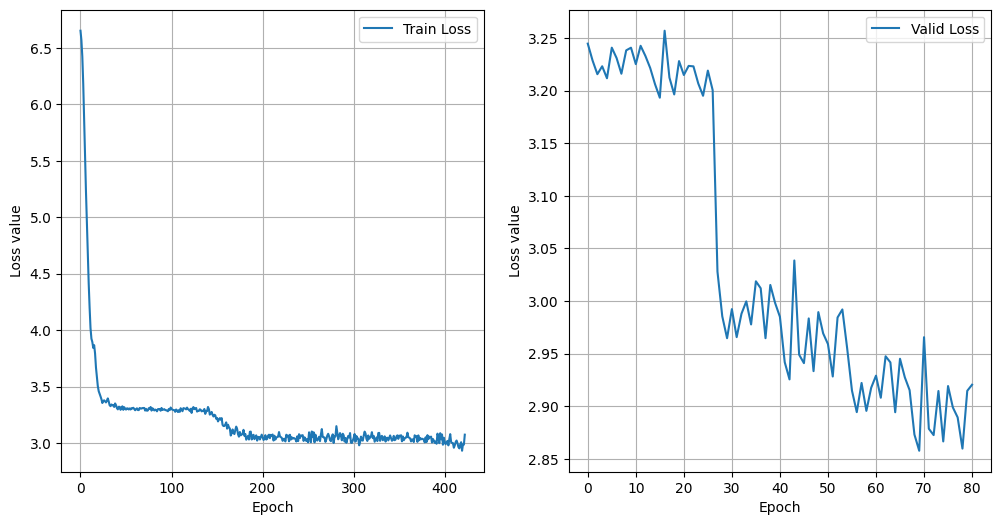

In [33]:
best_model = train_loop(
    model=model, 
    dataloader=dataloaders, 
    loss_func=loss_fn,
    optimizer=optimizer,
    parallel_type=parallel_type, 
    device=device, 
    early_stopping=10, 
    scheduler=scheduler, 
    epochs=3
    )

In [35]:
text2 = test(
    best_model, 
    prompt, 
    word_tokenize,
    token2idx, 
    idx2token, 
    vocabulary, 
    device, 
    generation_len=100, 
    T=1, 
    use_argmax=True
)

In [36]:
print(text2)

This will create a news after long can s
